# SESTM - Sentiment Extraction via Screening and Topic Modelling
This is a novel sentiment extraction algorithm that gleans sentiment from realised stock returns. This notebook will walk you through how the nitty gritty of how exactly it works

First things first, import this absolute monstrosity of imports; we'll be needing all of them.

In [1]:
import re
import sklearn
from scipy.optimize import fminbound
from sklearn import preprocessing
# import scikit-learn
import numpy as np
from numpy.linalg import inv
from pathlib import Path
from bs4 import BeautifulSoup as bs
# from textblob import TextBlob as tb
import math
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import json
import os
import random

In [14]:
# install nltk stuff
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/josh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/josh/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/josh/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Now that that's out of the way, let's define some sample articles to demonstrate how it works. Normally, I would pull articles from the Refinitiv Eikon API, which returns the webpage with the content inside. I've simulated this somwhat by using `<p>` tags, but the general idea for real articles is the same as these sample ones

Here are three sample articles that I made up:

In [2]:
article_1 = {
    'date': '2021-12-23 12:58:45.061000+00:00',
    'ticker': 'ABDN',
    'mrkt_info': {
        'open': 233.7,
        'close': 200.3
    },
    'html': '<p>John likes to watch films and eat pizza.\nMary likes pizza too.</p>'
}

article_2 = {
    'date': '2022-01-26 07:11:46.774000+00:00',
    'ticker': 'ABDN', 
    'mrkt_info': {
        'open': 229.2,
        'close': 241.0
    },
    'html': '<p>Mary also likes to watch football games and films. She prefers films. </p>'
}

article_3 = {
    'date': '2021-10-25 13:22:07.985000+00:00',
    'ticker': 'ABDN',
    'mrkt_info': {
        'open': 250.3,
        'close': 258.5
    },
    'html': '<p>Carl likes to play football. He finds films boring.</p>'
}

art_list = [article_1, article_2, article_3]

## Pre processing
We now need to define some things about these articles, namely:
1. The bag of words representation
2. The sign of the article (`sgn`)
3. The articles realised returns for article $i$ ($y_i$)

Steps 2 and 3 are the easiest, so let's do those first.

In [3]:
sgn = []    # list of article signs
y = []      # list of realised returns
i = 1

def calc_returns(article):
    returns = article['mrkt_info']['close'] - a['mrkt_info']['open']
    sgn_a = -1
    if (returns > 0): # add -1 if returns are 0 or less, 1 otherwise
        sgn_a = 1
    return (returns, sgn_a)

for a in art_list:
    (returns, sgn_a) = calc_returns(a)
    sgn.append(sgn_a)
    y.append(returns)
    print("Returns for article " + str(i) + ": " + str(returns))
    print("Sign for article " + str(i) + ": " + str(sgn_a))
    i +=1

Returns for article 1: -33.39999999999998
Sign for article 1: -1
Returns for article 2: 11.800000000000011
Sign for article 2: 1
Returns for article 3: 8.199999999999989
Sign for article 3: 1


Now we need to prepare the bag of words (BOW) representation for each of the articles. Before we can do that we need to *extract* the actual text content from the HTML, and then *normalise* the text content. Normlising consists of:
- Converting to lower case
- Removing non alphabetic chars
- Removing stop words (pronouns, connectives, etc.)
- Removing non-english words
- Lemmatising (converting likes to likes etc.)
- Tokenising (converting to list of words)

A bit of notation here:
- We have a collection of $n$ news articles and a dictionary of $m$ words
- We record the word counts in the $i^{th}$ article in vector $d_i$
    - $d_{i,j}$ is the number of times word $j$ appears in article $i$
    - $D = [d_{1}, ..., d_{n}]$ is an $m \times n$ doc-term matrix.
    - We occasionally work with a subset of columns where only indices are those with sentiment, we define this as $d_{[S],i}$

In [4]:
STOP_WORDS = set(stopwords.words('english'))
global_bow = {} # global bag of words
d = []          # word count vector d, where di is the word count vector for article i

def html_to_bow(html):
    readable_text = bs(html, 'lxml').get_text().lower()
    print("Text for article " + str(i) + ": '" + readable_text + "'")
    # substitute non alphabet chars (new lines become spaces)
    readable_text = re.sub(r'\n', ' ', readable_text)
    readable_text = re.sub(r'[^a-z ]', '', readable_text)
    # sub multiple spaces with one space
    readable_text = re.sub(r'\s+', ' ', readable_text)
    # tokenise text
    words = nltk.wordpunct_tokenize(readable_text)
    bow_art = {}
    if len(words) > 0:
        # lemmatise, remove non-english, and remove stopwords
        lemmatizer = WordNetLemmatizer()
        lemmatised_words = []
        en_words = set(nltk.corpus.words.words())
        for w in words:
            rootword = lemmatizer.lemmatize(w, pos="v")
            if rootword not in STOP_WORDS and rootword in en_words:
                lemmatised_words.append(rootword)
        # convert to bag of words
        # global_bow = {l: val+1 for l in lemmatised_words for val in global_bow.get(l, 0)}
        # bow_art = {l: val+1 for l in lemmatised_words for val in global_bow.get(l, 0)}
        for l in lemmatised_words:
            if l in bow_art:
                bow_art[l] += 1
            else:
                bow_art[l] = 1
    
    return bow_art

i = 1
for a in art_list:
    raw_html = a['html']
    if (raw_html): # when extracting articles from eikon, some articles are just pdfs, so this might not exist
            bow_art = html_to_bow(raw_html)
            print("BOW for article " + str(i) + ": " + str(bow_art))
            d.append(bow_art)
    i += 1

print(d)
print('\n')
# print("Global BOW: " + str(global_bow))


Text for article 1: 'john likes to watch films and eat pizza.
mary likes pizza too.'
BOW for article 1: {'like': 2, 'watch': 1, 'film': 1, 'eat': 1, 'pizza': 2, 'mary': 1}
Text for article 2: 'mary also likes to watch football games and films. she prefers films. '
BOW for article 2: {'mary': 1, 'also': 1, 'like': 1, 'watch': 1, 'football': 1, 'game': 1, 'film': 2, 'prefer': 1}
Text for article 3: 'carl likes to play football. he finds films boring.'
BOW for article 3: {'carl': 1, 'like': 1, 'play': 1, 'football': 1, 'find': 1, 'film': 1, 'bore': 1}
[{'like': 2, 'watch': 1, 'film': 1, 'eat': 1, 'pizza': 2, 'mary': 1}, {'mary': 1, 'also': 1, 'like': 1, 'watch': 1, 'football': 1, 'game': 1, 'film': 2, 'prefer': 1}, {'carl': 1, 'like': 1, 'play': 1, 'football': 1, 'find': 1, 'film': 1, 'bore': 1}]




## Screening for sentiment-charged words
With our BOWs now defined, we can move onto the maths.

Our first step calculates the frequency word $j$ co-occurs with a positive return:

$$f_j = \frac{\text{count of word } j \text{ in article with } sgn(y) = + 1}{\text{ count of word } j \text{ in all articles}}$$

In [5]:
def calc_f(d):
    pos_j = {}  #j occuring in positive article
    total_j = {}#j occuring in any article
    f = {}      #fraction of positive occurrences
    for i in range(len(d)):
        for w in d[i]:
            # pos_sent = sgn[i]
            pos_sent = 0
            if (sgn[i] == 1): pos_sent = 1
            if w in total_j:
                total_j[w] += d[i][w]
                pos_j[w] += d[i][w]*pos_sent
            else:
                total_j[w] = d[i][w]
                pos_j[w] = d[i][w]*pos_sent
            f[w] = pos_j[w]/total_j[w]
    return (pos_j, total_j, f)


(pos_j, total_j, f) = calc_f(d)
print("f_j = ")
for w in total_j:
    print(w + ": " + str(pos_j[w]) + "/" + str(total_j[w]))

f_j = 
like: 2/4
watch: 1/2
film: 3/4
eat: 0/1
pizza: 0/2
mary: 1/2
also: 1/1
football: 2/2
game: 1/1
prefer: 1/1
carl: 1/1
play: 1/1
find: 1/1
bore: 1/1


Now we can generate our list of sentiment charged words. Also, be aware that $\hat \pi$ is the fraction of articles marked with $sgn(y) = +1$. Normally, we would calculate this, but since there are only three, I'll just say it's $\hat \pi = 2/3$. In practice, $\hat \pi \approx 1/2$

At this point, we introduce some **hyper-parameters** that we can tune for an optimal model:
- $\alpha_{+}, \alpha_{-}$ are the upper and lower thresholds respectively that determine a word is sentimentally charged (or not). For this set of data, so that any word $j$ with $0.47 \le f_j \le 0.67$ is sentiment neutral, we set:
    - $\alpha_- = 0.2$ 
    - $\alpha_+ = 0$ 
- $\kappa$ is the minimum frequency with which a word should appear across all articles to avoid low frequency words messing up data.
    - Because our example dataset is very small, we will set $\kappa = 1$, so we remove this constraint for now.

This gives us the set of sentiment charged words $\hat S$:
$$\hat S = \{j: f_j \ge \hat \pi + \alpha_+ \text{ or } f_j \le \hat \pi - \alpha_-\} \cap \{j:k_j \ge \kappa\}$$

which in our case is

$$\hat S = \left\{j: f_j \ge \frac{2}{3} \text{ or } f_j \le \frac{2}{3} - 0.2 \right\} \cap \{j:k_j \ge 0 \}$$

In [6]:
#Hyper params
ALPHA_PLUS  = 0     # default for example: 0
ALPHA_MINUS = 0.2   # default for example: 0.2
KAPPA       = 1    # default for example: 1

In [7]:
def gen_sent_word_list(total_j,sgn):
    pi = sum(sgn_i > 0 for sgn_i in sgn)/len(sgn)
    print(pi)
    sentiment_words = [] # S
    neutral_words = []   # N
    for i in total_j:
        if ((f[i] >= pi + ALPHA_PLUS or f[i] <= pi - ALPHA_MINUS) and total_j[i] >= KAPPA):
            sentiment_words.append(i)
        else:
            neutral_words.append(i)
    return(sentiment_words, neutral_words)

(sentiment_words, neutral_words) = gen_sent_word_list(total_j,sgn)
print("S = " + str(sentiment_words))
print("N = " + str(neutral_words))

0.6666666666666666
S = ['film', 'eat', 'pizza', 'also', 'football', 'game', 'prefer', 'carl', 'play', 'find', 'bore']
N = ['like', 'watch', 'mary']


## Learning Sentiment Topics
Ok, so we have the wordlise $S$, now we just need to fit a two-topic model to these word counts. We gather these in a matrix $O = [O_+,O_-]$ which determines the expected counts of sentiment charged words in each article.

To measure how much article $i$ tilts in favour of a certain sentiment, we say the estimated sentiment of article $i$ is $\hat p_i$ such that:
$$\hat p_i = \frac{\text{rank of } y_i \text{ in } \{y_l\}_{l=1}^n}{n}$$

In [8]:
# Calculates p_i
def calc_p(y):
    p = [0] * len(y)
    for i, x in enumerate(sorted(range(len(y)), key=lambda y_lam: y[y_lam])):
        p[x] = float(1 - i/len(y))
    return p

p  = calc_p(y)
for i in range(len(p)):
    print("p_" + str(i+1) + ": " + str(p[i]))

p_1: 1.0
p_2: 0.33333333333333337
p_3: 0.6666666666666667


We also require the estimated $|S| \times 1$ vector of word frequencies for article $i$, denoted $\hat h_i$:
$$\hat h_i = \frac{d_{[S],i}}{\hat s_i} \quad \text{where } \hat s_i = \sum_{j \in \hat S} d_{j,i}$$

In [9]:

# Calculates s_i
def calc_s(sentiment_words, d):
    s = []                                          # ith element corresponds to total count of sentiment charged words for document i
    d_s = []                                        # ith element corresponds to list of word counts for each of the sentiment charged words for document i
    for doc in d:
        s.append(sum(doc.get(val,0) for val in sentiment_words))
        d_s.append([doc.get(val,0) for val in sentiment_words])
    return (s, d_s)

In [10]:
(s, d_s) = calc_s(sentiment_words,d)
for i in range(len(s)):
    print("s_" + str(i+1) + ":" + str(s[i]))
    print("d_(s," + str(i+1) + "):" + str(d_s[i]))

s_1:4
d_(s,1):[1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0]
s_2:6
d_(s,2):[2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
s_3:6
d_(s,3):[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]


In [11]:
# Calculates h_i
def calc_h(sentiment_words, d):
    h = np.zeros((len(d), len(sentiment_words)))    # ith element corresponds to |S|x1 vector of word frequencies divided by total sentiment words in doc i

    for i in range(len(d)):
        # subvector of sentiment words in d_i
        if (s[i] == 0) :
            h[i] = np.zeros(len(sentiment_words)).transpose()
        else:
            h[i] = np.array([(j/s[i]) for j in d_s[i]]).transpose()
    return h

In [12]:
h = calc_h(sentiment_words,d)
for i in range(len(h)):
    print("h_" + str(i+1) + ":" + str(h[i]))

h_1:[0.25 0.25 0.5  0.   0.   0.   0.   0.   0.   0.   0.  ]
h_2:[0.33333333 0.         0.         0.16666667 0.16666667 0.16666667
 0.16666667 0.         0.         0.         0.        ]
h_3:[0.16666667 0.         0.         0.         0.16666667 0.
 0.         0.16666667 0.16666667 0.16666667 0.16666667]



We now have all the tools we need to estimate $O$ ($\hat O$):
$$\hat O = [\hat h_1, \hat h_2, ..., \hat h_n] \widehat W' (\widehat W \widehat W')^{-1} \quad \text{where } \widehat W =
\begin{bmatrix}
\hat p_1 & \hat p_2 & \cdots & \hat p_n \\
1- \hat p_1 & 1-\hat p_2 & \cdots & 1-\hat p_n
\end{bmatrix}$$

Finally, we set all negative entries for $\hat O$ to 0, and normalise the columns to have $\ell^1$-norm

In [13]:
# Calculates O
def calc_o(p,h):
    p_inv = [(1-val) for val in p]
    W = np.column_stack((p, p_inv))
    W = W.transpose()
    ww = np.matmul(W,W.transpose())
    w2 = np.matmul(W.transpose(), inv(ww))
    O = np.matmul(h.transpose(),w2)
    O[O < 0] = 0 # remove negative entries of O
    O = O.transpose()
    # Normalise O columns to have l1 norm
    O = sklearn.preprocessing.normalize(O,norm='l1')
    #! swapped these around because otherwise it didnt make any sense (check this)
    temp0 = np.array(O[0])
    temp1 = np.array(O[1])
    O[1] = temp0
    O[0] = temp1
    O = O.transpose()
    return O

In [14]:
O = calc_o(p,h)
print("{: >10} {: >20} {: >20} {: >5}".format("Word", "O+", "O-", "f_j"))
print("==================================================================")
for i in range(len(O)):
    print("{: >10} {: >20} {: >20} {: >5}".format(sentiment_words[i] , str(O[i][0]), str(O[i][1]), str(f[sentiment_words[i]])))

      Word                   O+                   O-   f_j
      film   0.2222222222222222  0.19230769230769235  0.75
       eat                  0.0   0.1923076923076923   0.0
     pizza                  0.0   0.3846153846153846   0.0
      also  0.14814814814814817                  0.0   1.0
  football  0.18518518518518517 0.025641025641025664   1.0
      game  0.14814814814814817                  0.0   1.0
    prefer  0.14814814814814817                  0.0   1.0
      carl  0.03703703703703702 0.051282051282051294   1.0
      play  0.03703703703703702 0.051282051282051294   1.0
      find  0.03703703703703702 0.051282051282051294   1.0
      bore  0.03703703703703702 0.051282051282051294   1.0


You might notice here that the last few entries in $\hat O$ for this example are very close to equal in both positive and negative. This is because these entries correspond to sentiment-charged words that only appear in article 3, which would be ranked 2/3, or in other words, directly in the middle. This makes the word neutral overall in this context, evidenced by the two values being equal.

## Scoring new articles
With our shiny new estimates for sentiment-charged words and our $\hat O$, we can now estimate sentiment of articles not in our dataset. So, let's define a new article we want to estimate.

In [15]:
article_4 = {
    'date': '2022-02-15 16:23:17.923000+00:00',
    'ticker': 'ABDN',
    # 'mrkt_info': {
    #     'open': 250.3,
    #     'close': 258.5
    # },
    'html': '<p>Josh likes to play football. He finds films tiring.</p>'
}

It's basically the same as article 3, so we would expect the predicted outcome to have a similar $p$ to this article.

Let's turn it into a bag of words like before:

In [16]:
new_art_list = [article_4]
new_bow = {}
i = 1
for a in new_art_list:
    raw_html = a['html']
    if (raw_html): # when extracting articles from eikon, some articles are just pdfs, so this might not exist
        new_bow = html_to_bow(raw_html)
        print("BOW for article " + str(i) + ": " + str(bow_art))
    i += 1

Text for article 1: 'josh likes to play football. he finds films tiring.'
BOW for article 1: {'carl': 1, 'like': 1, 'play': 1, 'football': 1, 'find': 1, 'film': 1, 'bore': 1}


Before we get to the estimating, we need to calculate $\hat s$ for the new article (total count of words from $\hat S$).

In [17]:
new_s = sum(new_bow.get(w,0) for w in sentiment_words)
# for w in sentiment_words:
#     new_s += new_bow.get(w, 0)

print("new s: " + str(new_s))

new s: 4


Now, we just estimate $p_4$ using **maximum likelihood estimation** (MLE) because it is statistically efficient. We also add a penalty term $\lambda \log(p(1-p))$ where $\lambda > 0$ is a tuning parameter. This is to help with limited numbers of observations and low signal-to-noise ratios, to give us:

$$\hat p = \arg \max_{p \in [0,1]} \left\{ \hat s^{-1} \sum_{j\in \hat S} d_j \log \left( p \hat O_{+,j} + (1-p) \hat O_{-,j} \right) + \lambda \log(p(1-p))\right\}$$


In [18]:
def equation_to_solve(p_solve, new_bow, sentiment_words, new_s):
    i = 0
    equation = 0
    lam = 1
    for j in sentiment_words:
        # a = (new_bow.get(j,0) * math.log(new_p*O[i][0] + (1-new_p)*O[i][1]))
        d_j = new_bow.get(j,0)
        in_log = p_solve*O[i][0] + (1-p_solve)*O[i][1]
        if not in_log == 0:
            equation += d_j * math.log(p_solve*O[i][0] + (1-p_solve)*O[i][1])

        i += 1
        # i += 1/new_s + lam * (new_p*(1-new_p))

    # if new_s == 0:
    #     new_s = 1
    equation /= new_s
    equation += lam*(p_solve*(1-p_solve))
    equation *= -1 #flip equation for argmin
    return equation

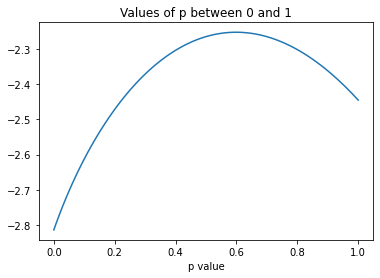

Argmax when p=0.5990137326322992
Sentiment words in article 3: {'play', 'football', 'carl', 'bore', 'film', 'find'}
Sentiment words in article 4: {'play', 'film', 'find', 'football'}


In [19]:
points = int(100)
xmin, xmax = 0.0, 1.0
xlist = np.linspace(0,1,101)
ylist = np.zeros(0)
index = 0
for x in xlist:
    ylist = np.append(ylist,equation_to_solve(x, new_bow, sentiment_words,new_s))
    index += 1
# xlist = map(lambda x: float(xmax - xmin)*x/points, range(points+1))
ylist *= -1
plt.plot(xlist, ylist)
plt.xlabel('p value')
plt.title(label='Values of p between 0 and 1')
plt.show()

est_p = fminbound(equation_to_solve, 0, 1, (new_bow, sentiment_words,new_s))
print("Argmax when p=" + str(est_p))
print("Sentiment words in article 3: " + str(set(list(d[2])).intersection(sentiment_words)))
print("Sentiment words in article 4: " + str(set(list(new_bow)).intersection(sentiment_words)))


The $p$ value is approximately 0.6, which is really close to that of article 3. Since it shares virtually all of the sentimentally charged words with this article, the estimation is good considering the sparse example dataset provided

We can also play around with different values of lambda to see which is best:

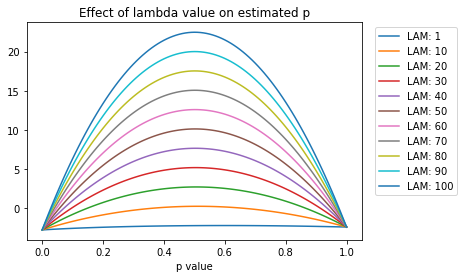

In [215]:

def equation_to_solve_lam(p_solve, lam):
    i = 0
    equation = 0
    # lam = 1
    for j in sentiment_words:
        # a = (new_bow.get(j,0) * math.log(new_p*O[i][0] + (1-new_p)*O[i][1]))
        d_j = new_bow.get(j,0)
        in_log = p_solve*O[i][0] + (1-p_solve)*O[i][1]
        if not in_log == 0:
            equation += d_j * math.log(p_solve*O[i][0] + (1-p_solve)*O[i][1])

        i += 1
        # i += 1/new_s + lam * (new_p*(1-new_p))

    equation /= new_s
    equation += lam*(p_solve*(1-p_solve))
    equation *= -1 #flip equation for argmin
    return equation

for lam in np.linspace(1,100,11):
    points = int(100)
    xmin, xmax = 0.0, 1.0
    xlist = np.linspace(0,1,101)
    ylist = np.zeros(0)
    index = 0
    for x in xlist:
        ylist = np.append(ylist,equation_to_solve_lam(x, lam))
        index += 1
    # xlist = map(lambda x: float(xmax - xmin)*x/points, range(points+1))
    est_p = fminbound(equation_to_solve, 0, 1, (new_bow, sentiment_words,new_s))
    ylist *= -1
    plt.plot(xlist, ylist, label="LAM: " + str(int(lam)))
plt.xlabel('p value')
plt.legend(bbox_to_anchor=(1.3,1), loc="upper right")
plt.title(label='Effect of lambda value on estimated p')
plt.show()

The predicted output tends toward 0.5 as the value of lambda increases

## Testing with real data
Now let's try with some real data I scraped using the eikon API. These articles are all concerning the stock market tickers 'III' or 'ABDN' and are from within the last 15 months. There are around 4k to play with here.

In [20]:
def extract_raw_article(article_path):
    pathlist = Path(article_path).rglob('*.json')
    art_list = []
    for path in pathlist:
        # open json
        with open(str(path)) as json_file:
            data = json.load(json_file)
            art_list.append(data)
    # return processed_articles
    return art_list

article_list = extract_raw_article(os.getcwd() + '/sestm/articles-pulled')
print("Loaded " + str(len(article_list)) + " articles")

Loaded 4015 articles


Let's preprocess this data. This will take around 10 minutes to process from scratch, so I have included the preprocessed data as a json file. This has does all of the processing (reading from file, generating bag of words, calculating signs, etc etc). If you want to do the processing now, set `PROCESS_ARTS` to true

In [21]:
# reset global variables
sgn = []
y = []
global_bow = {}
d = []
PROCESS_ARTS = False # flag to determine whether or not to process articles in notebook

if PROCESS_ARTS:
    for a in article_list:
        raw_html = a['html']
        if(raw_html):
            bow_art = html_to_bow(raw_html)
            (returns, sgn_a) = calc_returns(a)
            d.append(bow_art)
            sgn.append(sgn_a)
            y.append(returns)
else:
    with open('prev-data/word-vectors.json') as f:
        d = json.load(f)
    with open('prev-data/article-signs.json') as f:
        sgn = json.load(f)
    with open('prev-data/article-returns.json') as f:
        y = json.load(f)
print("Processing complete")

Processing complete


Let's now set aside 500 of these articles for testing purposes, and leave 3.5k for the training set. Here, I will just take the first 500, but with an even bigger data set, a *rolling-window* method will be used

In [22]:
testing_arts = 500
training_arts   = len(d) - testing_arts

testing_d   = d[:testing_arts]
testing_sgn = sgn[:testing_arts]
testing_y   = y[:testing_arts]

training_d      = d[testing_arts:]
training_sgn    = sgn[testing_arts:]
training_y      = y[testing_arts:]

print("Size of training data: " + str(training_arts))
print("Size of testing data: " + str(testing_arts))

Size of training data: 3385
Size of testing data: 500


Now we have our two distinct sets, let's train a model! Now would be a good time to rejig the hyper parameters, as the ones we used before will be really bad for real data

In [221]:
ALPHA_MINUS = 0.1   #default 0.1
ALPHA_PLUS  = 0.15  #default 0.15
KAPPA       = 10    #default 10

(pos_j, total_j, f)                 = calc_f(training_d)
(sentiment_words, neutral_words)    = gen_sent_word_list(total_j, training_sgn)
p           = calc_p(training_y)
(s, d_s)    = calc_s(sentiment_words, training_d)
h           = calc_h(sentiment_words, training_d)
O           = calc_o(p,h)

print(str(len(sentiment_words)) + " sentiment charged words\n")
# print(len(neutral_words))
tone = np.zeros(0)
for obj in O:
    tone = np.append(tone, obj[0] - obj[1])
top5 = tone.argsort()[-5:][::-1]
bot5 = tone.argsort()[::-1][-5:][::-1]
print("Top 5 most positive words")
for i in range(5):
    print(str(tone[top5[i]]) + " // " + sentiment_words[top5[i]])

print("Top 5 most negative words")
for i in range(5):
    print(str(tone[bot5[i]]) + " // " + sentiment_words[bot5[i]])
print("Model trained")

0.451698670605613
480 sentiment charged words

Top 5 most positive words
0.027793425306020043 // r
0.02215782567326895 // aeon
0.021742435535202737 // q
0.014708118269400616 // index
0.014573068589111258 // energy
Top 5 most negative words
-0.07463302535079452 // underlie
-0.021867392725907202 // mar
-0.014038100456705983 // operate
-0.012554602860103153 // mobile
-0.008259319996351957 // vice
Model trained


With the model trained, we can use the testing data to validate the model and see how it did vs real world data.

In [238]:
est_p_test = []
for test_index in range(len(testing_d)):
    est_p = 0
    testing_bow = testing_d[test_index]

    testing_s = sum(testing_bow.get(w,0) for w in sentiment_words)
    if (testing_s > 0):
        est_p = fminbound(equation_to_solve, 0, 1, (testing_bow, sentiment_words,testing_s))
    est_p_test.append(est_p)

print("Max estimated p: " + str(max(est_p_test)))
print("Min estimated p: " + str(min(est_p_test)))


Max estimated p: 0.9999935391945708
Min estimated p: 0


In [257]:
test_index = 308
est_p = 0
testing_bow = testing_d[test_index]

testing_s = sum(testing_bow.get(w,0) for w in sentiment_words)
# print(testing_bow)
# for w in sentiment_words:
#     count_sent = testing_bow.get(w,0)
#     if count_sent > 0:
#         print(w+ ":" + str(testing_bow.get(w,0)))
print(set(testing_bow).intersection(sentiment_words))
points = int(100)
xmin, xmax = 0.0, 1.0
xlist = np.linspace(0,1,101)
ylist = np.zeros(0)
index = 0
if (testing_s == 0):
    print("No sentiment charged words")
else:
    for x in xlist:
        ylist = np.append(ylist,equation_to_solve(x, testing_bow, sentiment_words,testing_s))
        index += 1
    # xlist = map(lambda x: float(xmax - xmin)*x/points, range(points+1))
    ylist *= -1
    plt.plot(xlist, ylist)
    plt.xlabel('p value')
    plt.title(label='Values of p between 0 and 1 for article ' + str(test_index))
    plt.show()

    est_p = fminbound(equation_to_solve, 0, 1, (testing_bow, sentiment_words,testing_s))
    print("No sentiment words: " + str(testing_s))
    print("Argmax when p=" + str(est_p))
    # print("Real p = " + calc_p(training_y.append(testing_y[test_index]))
    print("Real returns = " + str(testing_y[test_index]))

set()
No sentiment charged words
